In [2]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf

from sklearn.model_selection import train_test_split


2023-03-06 12:37:05.864387: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 12:37:05.978161: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-06 12:37:05.978178: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-06 12:37:06.735560: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
df = pd.read_csv('./data/processed_data.csv')
df.shape


(18471, 69)

In [11]:
df_caregiver = pd.read_csv('data/processed_caregiver_data.csv', header=0)
df_caregiver.shape

(14221, 6)

In [5]:
# Final labels
labels = ['patientState_good', 'patientState_caution', 'patientState_danger']
# Section labels
section_labels = {
    'fever': ['feverState_good', 'feverState_caution', 'feverState_danger'],
    'medication': ['medicationState_good', 'medicationState_caution', 'medicationState_danger'],
    'hydration': ['hydrationState_good', 'hydrationState_caution', 'hydrationState_danger'],
    'respiration': ['respirationState_good', 'respirationState_caution', 'respirationState_danger'],
    'skin': ['skinState_good', 'skinState_caution', 'skinState_danger'],
    'pulse': ['pulseState_good', 'pulseState_caution', 'pulseState_danger'],
    'general': ['generalState_good', 'generalState_caution', 'generalState_danger'],
}

caregiver_labels = ['caregiverState_good', 'caregiverState_caution', 'caregiverState_danger']
caregiver_features = ['caregiverFeel', 'caregiverThink', 'caregiverConfident']

section_features = {
    'fever': ['ageInMonths', 'temperature', 'feverDuration'],
    'medication': [
        'antibiotics',
        'antibioticsHowMany',
        'antibioticsHowMuch',
        'antipyretic',
        'antipyreticHowMany',
        'antipyreticHowMuch'],
    'hydration': [
        'crying',
        'diarrhea',
        'drinking',
        'lastUrination',
        'skinTurgor',
        'tearsWhenCrying',
        'tongue',
        'vomit-01-No', 'vomit-02-Slight', 'vomit-03-Frequent', 'vomit-04-Yellow', 'vomit-05-5<hours'],
    'respiration': [
        'dyspnea',
        'respiratoryRate',
        'wheezing',
        'ageInMonths'],
    'skin': ['glassTest', 'rash', 'skinColor'],
    'pulse': ['pulse', 'ageInMonths'],
    'general': [
        'awareness-01-Normal', 'awareness-02-SleepyOddOrFeverishNightmares', 'awareness-03-NoReactionsNoAwareness',
        'bulgingFontanelleMax18MOld',
        'exoticTrip',
        'lastTimeEating',
        'pain-01-No', 'pain-02-FeelingBad', 'pain-03-Headache', 'pain-04-SwollenPainful', 'pain-05-StrongBellyacheAche',
        'painfulUrination',
        'seizure',
        'smellyUrine',
        'vaccinationIn14days',
        'vaccinationHowManyHoursAgo',
        'wryNeck'],
}
# Section labels in an array flattened
section_labels_arr = [item for val in section_labels.values() for item in val]
# All labels
all_labels = [*labels, *section_labels_arr]


In [7]:
# Separating to testing and training

# Prepare the data: You should split your data into training and test sets.
# The training set will be used to train the model and the test set will be used
# to evaluate the model's performance.
def split(dataset, ground_truth, test_size=0.2, val_size=0.2):
    _x, x_test, _y, y_test = train_test_split(
        dataset.to_numpy(),
        ground_truth.to_numpy(),
        test_size=test_size,
        random_state=42
    )
    x_train, x_val, y_train, y_val = train_test_split(
        _x,
        _y,
        test_size=val_size / 0.8,
        random_state=42
    )
    return x_train, np.argmax(y_train, axis=1), x_val, np.argmax(y_val, axis=1), x_test, np.argmax(y_test, axis=1)


In [8]:
import tensorflow_decision_forests as tfdf


In [22]:
def create_model():
    model = tfdf.keras.RandomForestModel()
    model.compile(metrics=['accuracy'])
    return model


In [28]:

models = {}
model_results = {}

for key in section_features.keys():
    x_train, y_train, x_val, y_val, x_test, y_test = split(
        df[section_features[key]],
        df[section_labels[key]]
    )

    model = create_model()
    model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), verbose=0)

    loss, acc = model.evaluate(x=x_test, y=y_test)

    model_results[key] = [acc]

    models[key] = model

cg_x_train, cg_y_train, cg_x_val, cg_y_val, cg_x_test, cg_y_test = split(
    df_caregiver[caregiver_features],
    df_caregiver[caregiver_labels],
)

caregiver_model = create_model()
caregiver_model.fit(x=cg_x_train, y=cg_y_train, validation_data=(cg_x_val, cg_y_val), verbose=0)

loss, acc = caregiver_model.evaluate(x=cg_x_test, y=cg_y_test)

model_results['caregiver'] = acc

models['caregiver'] = caregiver_model

Use /tmp/tmpu58mpr09 as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:21.724188096+01:00 kernel.cc:1214] Loading model from path /tmp/tmpu58mpr09/model/ with prefix 12d9429014ea446f
[INFO 2023-03-06T13:17:21.808691182+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 36376 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:17:21.808736025+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:17:21.808762105+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9968
Use /tmp/tmp4rnj8utj as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:23.163398227+01:00 kernel.cc:1214] Loading model from path /tmp/tmp4rnj8utj/model/ with prefix 5a2b32d7046f4ad7
[INFO 2023-03-06T13:17:23.170889022+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3312 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:17:23.170918554+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9992
Use /tmp/tmpv4ph_4ah as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:24.944452539+01:00 kernel.cc:1214] Loading model from path /tmp/tmpv4ph_4ah/model/ with prefix 7b84fe7bf5f84642
[INFO 2023-03-06T13:17:25.005233432+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 27882 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:17:25.005265533+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9970
Use /tmp/tmp5oc3bhqb as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:27.021864207+01:00 kernel.cc:1214] Loading model from path /tmp/tmp5oc3bhqb/model/ with prefix 5f8ae472e0d544bf
[INFO 2023-03-06T13:17:27.4277746+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 165856 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:17:27.427807624+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9497
Use /tmp/tmp2sbc7blt as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:29.221690618+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2sbc7blt/model/ with prefix b9c17841efe44f3d
[INFO 2023-03-06T13:17:29.230686004+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3300 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:17:29.230713982+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpmw7ebquw as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:31.031345414+01:00 kernel.cc:1214] Loading model from path /tmp/tmpmw7ebquw/model/ with prefix 1ef7037a007c409d
[INFO 2023-03-06T13:17:31.432733147+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 171032 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:17:31.432766326+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9510
Use /tmp/tmpav34qe6x as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:33.771677649+01:00 kernel.cc:1214] Loading model from path /tmp/tmpav34qe6x/model/ with prefix b26bd8dd6e6949cc
[INFO 2023-03-06T13:17:33.828825557+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 25772 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:17:33.828855298+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:17:33.828875627+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9968
Use /tmp/tmpl83pdk_0 as temporary training directory
Num validation examples: tf.Tensor(2844, shape=(), dtype=int32)


[INFO 2023-03-06T13:17:35.073881427+01:00 kernel.cc:1214] Loading model from path /tmp/tmpl83pdk_0/model/ with prefix 91b77f75d29243f8
[INFO 2023-03-06T13:17:35.08560839+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5564 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:17:35.085634318+01:00 kernel.cc:1046] Use fast generic engine


89/89 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993


In [29]:
model_results

{'fever': [0.9967523813247681],
 'medication': [0.9991880655288696],
 'hydration': [0.9970229864120483],
 'respiration': [0.9496617317199707],
 'skin': [1.0],
 'pulse': [0.9510148763656616],
 'general': [0.9967523813247681],
 'caregiver': 0.999297022819519}

In [30]:
from sklearn.model_selection import KFold

n_split = 10


def cross_validate(X, Y):
    results = []
    for train_index, test_index in KFold(n_split).split(X):
        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]

        model = create_model()
        model.fit(x_train, y_train, verbose=0)

        loss, acc = model.evaluate(x_test, y_test)
        results.append(acc)
    return results


In [31]:
cross_results = {}
for key in section_features.keys():
    print('================', key, '================')
    cross_validate_result = cross_validate(
        df[section_features[key]].to_numpy(),
        np.argmax(df[section_labels[key]].to_numpy(), axis=1)
    )
    cross_results[key] = cross_validate_result

print('================', 'caregiver', '================')
cross_validate_result = cross_validate(
    df_caregiver[caregiver_features].to_numpy(),
    np.argmax(df_caregiver[caregiver_labels].to_numpy(), axis=1)
)
cross_results['caregiver'] = cross_validate_result
cross_results


================ fever ================
Use /tmp/tmph5ea1w1l as temporary training directory


[INFO 2023-03-06T13:18:10.614410134+01:00 kernel.cc:1214] Loading model from path /tmp/tmph5ea1w1l/model/ with prefix ee4c9a0fe66148a1
[INFO 2023-03-06T13:18:10.723493932+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 45814 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:10.723531574+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:18:10.723554557+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmpobuuhcd8 as temporary training directory


[INFO 2023-03-06T13:18:12.16836915+01:00 kernel.cc:1214] Loading model from path /tmp/tmpobuuhcd8/model/ with prefix 91799306acbe40db
[INFO 2023-03-06T13:18:12.265775833+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 43662 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:12.265806823+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9951
Use /tmp/tmpamczwm6n as temporary training directory


[INFO 2023-03-06T13:18:13.824118071+01:00 kernel.cc:1214] Loading model from path /tmp/tmpamczwm6n/model/ with prefix 0af346be740a4e0b
[INFO 2023-03-06T13:18:13.941208359+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 43348 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:13.941240638+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9940
Use /tmp/tmpljnytnv3 as temporary training directory


[INFO 2023-03-06T13:18:15.359167798+01:00 kernel.cc:1214] Loading model from path /tmp/tmpljnytnv3/model/ with prefix 9696736252174764
[INFO 2023-03-06T13:18:15.463749539+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 44974 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:15.4637796+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmp191b1fjs as temporary training directory


[INFO 2023-03-06T13:18:16.949558485+01:00 kernel.cc:1214] Loading model from path /tmp/tmp191b1fjs/model/ with prefix 739a9dc4d2df440d
[INFO 2023-03-06T13:18:17.054261631+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 46456 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:17.054297425+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmph8re5qpd as temporary training directory


[INFO 2023-03-06T13:18:18.575436843+01:00 kernel.cc:1214] Loading model from path /tmp/tmph8re5qpd/model/ with prefix 206983d88acf4499
[INFO 2023-03-06T13:18:18.670065385+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 42206 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:18.670097167+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9946
Use /tmp/tmpiy7sd1bm as temporary training directory


[INFO 2023-03-06T13:18:20.252061821+01:00 kernel.cc:1214] Loading model from path /tmp/tmpiy7sd1bm/model/ with prefix acd6b87f33ff425e
[INFO 2023-03-06T13:18:20.372406898+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 47594 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:20.372443008+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmpw2i_0439 as temporary training directory


[INFO 2023-03-06T13:18:22.005784935+01:00 kernel.cc:1214] Loading model from path /tmp/tmpw2i_0439/model/ with prefix ce101704971a49ca
[INFO 2023-03-06T13:18:22.115748991+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 46136 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:22.115778599+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:18:22.115795044+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmp8u3pael9 as temporary training directory


[INFO 2023-03-06T13:18:23.667219077+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8u3pael9/model/ with prefix b95169490fcf41b6
[INFO 2023-03-06T13:18:23.773999647+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 45000 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:23.774032113+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9962
Use /tmp/tmpcu20jezm as temporary training directory


[INFO 2023-03-06T13:18:25.184738437+01:00 kernel.cc:1214] Loading model from path /tmp/tmpcu20jezm/model/ with prefix 0a89e9b127754a56
[INFO 2023-03-06T13:18:25.284574791+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 44320 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:18:25.284606034+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9940
================ medication ================
Use /tmp/tmp058v_pmr as temporary training directory


[INFO 2023-03-06T13:18:26.104248578+01:00 kernel.cc:1214] Loading model from path /tmp/tmp058v_pmr/model/ with prefix fa685fe775334dde
[INFO 2023-03-06T13:18:26.113986957+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4374 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:26.114013045+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpax1feebm as temporary training directory


[INFO 2023-03-06T13:18:26.914187635+01:00 kernel.cc:1214] Loading model from path /tmp/tmpax1feebm/model/ with prefix f32a7877514049a3
[INFO 2023-03-06T13:18:26.923555586+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4136 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:26.923582766+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp8ya9fil0 as temporary training directory


[INFO 2023-03-06T13:18:27.71062358+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8ya9fil0/model/ with prefix c993de9187f74959
[INFO 2023-03-06T13:18:27.721377267+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4288 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:27.721410478+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9984
Use /tmp/tmpupg9wd96 as temporary training directory


[INFO 2023-03-06T13:18:28.60897352+01:00 kernel.cc:1214] Loading model from path /tmp/tmpupg9wd96/model/ with prefix 66084a868831492e
[INFO 2023-03-06T13:18:28.616428208+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3370 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:28.616453659+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9995
Use /tmp/tmpn_iaugcb as temporary training directory


[INFO 2023-03-06T13:18:29.386845704+01:00 kernel.cc:1214] Loading model from path /tmp/tmpn_iaugcb/model/ with prefix b7e4042ff9b44ab4
[INFO 2023-03-06T13:18:29.394737796+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3592 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:29.394764964+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9984
Use /tmp/tmpjrxnoogv as temporary training directory


[INFO 2023-03-06T13:18:30.174374253+01:00 kernel.cc:1214] Loading model from path /tmp/tmpjrxnoogv/model/ with prefix 89ee45e92089451d
[INFO 2023-03-06T13:18:30.184299094+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4122 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:30.184332651+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp7apdsrlf as temporary training directory


[INFO 2023-03-06T13:18:30.965620201+01:00 kernel.cc:1214] Loading model from path /tmp/tmp7apdsrlf/model/ with prefix 78431d1fcc1d41a4
[INFO 2023-03-06T13:18:30.974424563+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4010 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:30.974450221+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmphm0kqkq8 as temporary training directory


[INFO 2023-03-06T13:18:31.775407246+01:00 kernel.cc:1214] Loading model from path /tmp/tmphm0kqkq8/model/ with prefix 2e35339711184a4a
[INFO 2023-03-06T13:18:31.784267958+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4026 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:31.784301761+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9995
Use /tmp/tmpkwu6nvmi as temporary training directory


[INFO 2023-03-06T13:18:32.581434708+01:00 kernel.cc:1214] Loading model from path /tmp/tmpkwu6nvmi/model/ with prefix f3619bfbacbf47e3
[INFO 2023-03-06T13:18:32.59072507+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4018 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:32.59074928+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:18:32.590763063+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp_ujeuj9n as temporary training directory


[INFO 2023-03-06T13:18:33.401102908+01:00 kernel.cc:1214] Loading model from path /tmp/tmp_ujeuj9n/model/ with prefix ed2f884abe4443e4
[INFO 2023-03-06T13:18:33.409831303+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4038 node(s), and 6 input feature(s).
[INFO 2023-03-06T13:18:33.409857012+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
================ hydration ================
Use /tmp/tmpwkgec7ju as temporary training directory


[INFO 2023-03-06T13:18:35.094620769+01:00 kernel.cc:1214] Loading model from path /tmp/tmpwkgec7ju/model/ with prefix bf99eceacf564a9c
[INFO 2023-03-06T13:18:35.165492798+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30914 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:35.165535461+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9962
Use /tmp/tmpyd31tntd as temporary training directory


[INFO 2023-03-06T13:18:36.858328692+01:00 kernel.cc:1214] Loading model from path /tmp/tmpyd31tntd/model/ with prefix 9d6c0b6de11349a0
[INFO 2023-03-06T13:18:36.931765581+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31478 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:36.931797139+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9995
Use /tmp/tmpwsvhl9yk as temporary training directory


[INFO 2023-03-06T13:18:38.626087217+01:00 kernel.cc:1214] Loading model from path /tmp/tmpwsvhl9yk/model/ with prefix ead2c0713831472a
[INFO 2023-03-06T13:18:38.710884312+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31190 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:38.710916843+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9989
Use /tmp/tmpf_g79mlw as temporary training directory


[INFO 2023-03-06T13:18:40.371228213+01:00 kernel.cc:1214] Loading model from path /tmp/tmpf_g79mlw/model/ with prefix 02e232c0b2064091
[INFO 2023-03-06T13:18:40.440328063+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30496 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:40.440361751+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9962
Use /tmp/tmpnthi3e07 as temporary training directory


[INFO 2023-03-06T13:18:42.649816493+01:00 kernel.cc:1214] Loading model from path /tmp/tmpnthi3e07/model/ with prefix 9f588452d04f4377
[INFO 2023-03-06T13:18:42.726330369+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30660 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:42.726359616+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:18:42.726385786+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmpkz7rjefk as temporary training directory


[INFO 2023-03-06T13:18:44.476334104+01:00 kernel.cc:1214] Loading model from path /tmp/tmpkz7rjefk/model/ with prefix d3a5e157a7ff4406
[INFO 2023-03-06T13:18:44.547467997+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31284 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:44.547500465+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9984
Use /tmp/tmpm3q374m7 as temporary training directory


[INFO 2023-03-06T13:18:46.305882165+01:00 kernel.cc:1214] Loading model from path /tmp/tmpm3q374m7/model/ with prefix 9c11c42ac02b495c
[INFO 2023-03-06T13:18:46.384905845+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30990 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:46.384935474+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmp0ern16lm as temporary training directory


[INFO 2023-03-06T13:18:48.073249803+01:00 kernel.cc:1214] Loading model from path /tmp/tmp0ern16lm/model/ with prefix e9459f8480f24736
[INFO 2023-03-06T13:18:48.140046022+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 30626 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:48.140080678+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmpxtubw1at as temporary training directory


[INFO 2023-03-06T13:18:49.852178121+01:00 kernel.cc:1214] Loading model from path /tmp/tmpxtubw1at/model/ with prefix 175f7a257e2b4261
[INFO 2023-03-06T13:18:49.939104379+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31174 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:49.939135556+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmpu2knltn7 as temporary training directory


[INFO 2023-03-06T13:18:51.685522776+01:00 kernel.cc:1214] Loading model from path /tmp/tmpu2knltn7/model/ with prefix 917098f242a64b80
[INFO 2023-03-06T13:18:51.755982802+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 31804 node(s), and 12 input feature(s).
[INFO 2023-03-06T13:18:51.756013636+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9962
================ respiration ================
Use /tmp/tmpsrcyofwj as temporary training directory


[INFO 2023-03-06T13:18:53.842217072+01:00 kernel.cc:1214] Loading model from path /tmp/tmpsrcyofwj/model/ with prefix 5719db8403fb45ac
[INFO 2023-03-06T13:18:54.303885152+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 203056 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:18:54.303916024+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:18:54.30393179+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9172
Use /tmp/tmp2fp404vb as temporary training directory


[INFO 2023-03-06T13:18:56.387269834+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2fp404vb/model/ with prefix cc08d129035142ff
[INFO 2023-03-06T13:18:56.843887816+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 206290 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:18:56.843920791+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9534
Use /tmp/tmpfu18d7nn as temporary training directory


[INFO 2023-03-06T13:18:58.95973915+01:00 kernel.cc:1214] Loading model from path /tmp/tmpfu18d7nn/model/ with prefix e5d409f87fb843b6
[INFO 2023-03-06T13:18:59.431919355+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 212772 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:18:59.431953258+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9475
Use /tmp/tmpshnd2sc4 as temporary training directory


[INFO 2023-03-06T13:19:01.606088258+01:00 kernel.cc:1214] Loading model from path /tmp/tmpshnd2sc4/model/ with prefix cc07423972a04ef9
[INFO 2023-03-06T13:19:02.046565654+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 202902 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:02.046600254+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9399
Use /tmp/tmpm3w3xxbu as temporary training directory


[INFO 2023-03-06T13:19:04.192826381+01:00 kernel.cc:1214] Loading model from path /tmp/tmpm3w3xxbu/model/ with prefix 2de1ad9b0a824543
[INFO 2023-03-06T13:19:04.651296351+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 203256 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:04.651334937+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:19:04.651356434+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9442
Use /tmp/tmpwoljy_8g as temporary training directory


[INFO 2023-03-06T13:19:06.816369996+01:00 kernel.cc:1214] Loading model from path /tmp/tmpwoljy_8g/model/ with prefix 20468fd707154ab4
[INFO 2023-03-06T13:19:07.274921449+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 200886 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:07.274954077+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9356
Use /tmp/tmpz4xudkog as temporary training directory


[INFO 2023-03-06T13:19:09.381503308+01:00 kernel.cc:1214] Loading model from path /tmp/tmpz4xudkog/model/ with prefix fc016b1f158d4bb6
[INFO 2023-03-06T13:19:09.854189151+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 209056 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:09.854230029+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9193
Use /tmp/tmpgjqswg3l as temporary training directory


[INFO 2023-03-06T13:19:11.964957511+01:00 kernel.cc:1214] Loading model from path /tmp/tmpgjqswg3l/model/ with prefix 7f3d711833904006
[INFO 2023-03-06T13:19:12.434488878+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 211456 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:12.434521746+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9518
Use /tmp/tmp4a8g41rg as temporary training directory


[INFO 2023-03-06T13:19:14.614670639+01:00 kernel.cc:1214] Loading model from path /tmp/tmp4a8g41rg/model/ with prefix df81c279d5f9429d
[INFO 2023-03-06T13:19:15.081992723+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 211464 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:15.082030236+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:19:15.08205144+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9302
Use /tmp/tmpjwljk2li as temporary training directory


[INFO 2023-03-06T13:19:17.2183704+01:00 kernel.cc:1214] Loading model from path /tmp/tmpjwljk2li/model/ with prefix 87a3622f7e2c49d4
[INFO 2023-03-06T13:19:17.677090637+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 205402 node(s), and 4 input feature(s).
[INFO 2023-03-06T13:19:17.677123522+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9507
================ skin ================
Use /tmp/tmpbqy1xzr6 as temporary training directory


[INFO 2023-03-06T13:19:18.522171918+01:00 kernel.cc:1214] Loading model from path /tmp/tmpbqy1xzr6/model/ with prefix c0576d3c48154fa6
[INFO 2023-03-06T13:19:18.529441815+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3302 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:18.529486039+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp4nikd27v as temporary training directory


[INFO 2023-03-06T13:19:19.236138002+01:00 kernel.cc:1214] Loading model from path /tmp/tmp4nikd27v/model/ with prefix eeab60e007864a1e
[INFO 2023-03-06T13:19:19.243004298+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3300 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:19.243047949+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9995
Use /tmp/tmp1zx5_t88 as temporary training directory


[INFO 2023-03-06T13:19:19.906169069+01:00 kernel.cc:1214] Loading model from path /tmp/tmp1zx5_t88/model/ with prefix aeab92c6f1b84bdc
[INFO 2023-03-06T13:19:19.912875089+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:19.912909176+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpuxe0f1o9 as temporary training directory


[INFO 2023-03-06T13:19:20.584500606+01:00 kernel.cc:1214] Loading model from path /tmp/tmpuxe0f1o9/model/ with prefix 9bf06191655c46c2
[INFO 2023-03-06T13:19:20.59329371+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:20.593333966+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpmbgh95k0 as temporary training directory


[INFO 2023-03-06T13:19:21.253906172+01:00 kernel.cc:1214] Loading model from path /tmp/tmpmbgh95k0/model/ with prefix 292271e41cfb4942
[INFO 2023-03-06T13:19:21.261246897+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:21.261272077+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp0b99qnd6 as temporary training directory


[INFO 2023-03-06T13:19:21.934866844+01:00 kernel.cc:1214] Loading model from path /tmp/tmp0b99qnd6/model/ with prefix 1694624635744146
[INFO 2023-03-06T13:19:21.9419505+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:21.941984844+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp9_l0_rd2 as temporary training directory


[INFO 2023-03-06T13:19:22.65418354+01:00 kernel.cc:1214] Loading model from path /tmp/tmp9_l0_rd2/model/ with prefix 04a0d4cdea444a25
[INFO 2023-03-06T13:19:22.66095195+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:22.660995497+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp8r50b4jr as temporary training directory


[INFO 2023-03-06T13:19:23.333591371+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8r50b4jr/model/ with prefix 8668bdafcbd04b39
[INFO 2023-03-06T13:19:23.340875307+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:23.340912422+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpw4_bv064 as temporary training directory


[INFO 2023-03-06T13:19:24.036358101+01:00 kernel.cc:1214] Loading model from path /tmp/tmpw4_bv064/model/ with prefix e6c0955ef0ac4eb6
[INFO 2023-03-06T13:19:24.043778168+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:24.04380292+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpn06_ys1q as temporary training directory


[INFO 2023-03-06T13:19:24.747986032+01:00 kernel.cc:1214] Loading model from path /tmp/tmpn06_ys1q/model/ with prefix f73d37ff52d44ff2
[INFO 2023-03-06T13:19:24.755089463+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 3304 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:19:24.755111623+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
================ pulse ================
Use /tmp/tmpd83wiclt as temporary training directory


[INFO 2023-03-06T13:19:26.494734571+01:00 kernel.cc:1214] Loading model from path /tmp/tmpd83wiclt/model/ with prefix eaa3fd309ef949d1
[INFO 2023-03-06T13:19:27.062908496+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 234604 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:27.062938888+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:19:27.062954087+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9470
Use /tmp/tmpc36m_ncx as temporary training directory


[INFO 2023-03-06T13:19:28.96790632+01:00 kernel.cc:1214] Loading model from path /tmp/tmpc36m_ncx/model/ with prefix 3cfb3328f32a4c29
[INFO 2023-03-06T13:19:29.489159598+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 233858 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:29.489200756+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9372
Use /tmp/tmpyl2ehjqz as temporary training directory


[INFO 2023-03-06T13:19:31.387685536+01:00 kernel.cc:1214] Loading model from path /tmp/tmpyl2ehjqz/model/ with prefix 2763ce6b287f44c8
[INFO 2023-03-06T13:19:31.918692822+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 236210 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:31.918725949+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9507
Use /tmp/tmp9bus2mgx as temporary training directory


[INFO 2023-03-06T13:19:33.805227823+01:00 kernel.cc:1214] Loading model from path /tmp/tmp9bus2mgx/model/ with prefix 4b0ffe2a0d264f91
[INFO 2023-03-06T13:19:34.326234443+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 231844 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:34.326269764+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 3ms/step - loss: 0.0000e+00 - accuracy: 0.9453
Use /tmp/tmpz3fho2vc as temporary training directory


[INFO 2023-03-06T13:19:36.243574229+01:00 kernel.cc:1214] Loading model from path /tmp/tmpz3fho2vc/model/ with prefix f688d17fcc024a32
[INFO 2023-03-06T13:19:36.754950806+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 233364 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:36.754984721+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9529
Use /tmp/tmph89ptfyk as temporary training directory


[INFO 2023-03-06T13:19:38.574238735+01:00 kernel.cc:1214] Loading model from path /tmp/tmph89ptfyk/model/ with prefix 54f8505341dc4e75
[INFO 2023-03-06T13:19:39.102538261+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 232202 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:39.102569032+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:19:39.102584265+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9448
Use /tmp/tmpvkpx1uw7 as temporary training directory


[INFO 2023-03-06T13:19:40.975057832+01:00 kernel.cc:1214] Loading model from path /tmp/tmpvkpx1uw7/model/ with prefix e21a28f306eb48da
[INFO 2023-03-06T13:19:41.48776879+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 230864 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:41.487800123+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 1s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9231
Use /tmp/tmpqa_m0zf3 as temporary training directory


[INFO 2023-03-06T13:19:43.907528629+01:00 kernel.cc:1214] Loading model from path /tmp/tmpqa_m0zf3/model/ with prefix 7edb194a299345d0
[INFO 2023-03-06T13:19:44.470112834+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 234168 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:44.470146038+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9464
Use /tmp/tmp8rqesuhw as temporary training directory


[INFO 2023-03-06T13:19:46.444874353+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8rqesuhw/model/ with prefix 1b18e4c802af4ce6
[INFO 2023-03-06T13:19:46.981098595+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 232366 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:46.981131568+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9410
Use /tmp/tmpce7auxqk as temporary training directory


[INFO 2023-03-06T13:19:48.896539072+01:00 kernel.cc:1214] Loading model from path /tmp/tmpce7auxqk/model/ with prefix e0c0405038894324
[INFO 2023-03-06T13:19:49.431541151+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 233668 node(s), and 2 input feature(s).
[INFO 2023-03-06T13:19:49.431571007+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:19:49.431586951+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9561
================ general ================
Use /tmp/tmpixcl32ah as temporary training directory


[INFO 2023-03-06T13:19:51.503822293+01:00 kernel.cc:1214] Loading model from path /tmp/tmpixcl32ah/model/ with prefix 92ddfda531b84fe1
[INFO 2023-03-06T13:19:51.570059298+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28206 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:19:51.570093409+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9881
Use /tmp/tmpt35a8_01 as temporary training directory


[INFO 2023-03-06T13:19:53.697446058+01:00 kernel.cc:1214] Loading model from path /tmp/tmpt35a8_01/model/ with prefix 4dd67f84edfe49fb
[INFO 2023-03-06T13:19:53.762635791+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29122 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:19:53.762669013+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9962
Use /tmp/tmpi_uowlr6 as temporary training directory


[INFO 2023-03-06T13:19:55.808945726+01:00 kernel.cc:1214] Loading model from path /tmp/tmpi_uowlr6/model/ with prefix db59447c7a714b52
[INFO 2023-03-06T13:19:55.871037617+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28408 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:19:55.871089434+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9892
Use /tmp/tmpgarlwkzk as temporary training directory


[INFO 2023-03-06T13:19:57.984834476+01:00 kernel.cc:1214] Loading model from path /tmp/tmpgarlwkzk/model/ with prefix ec679997f41548dd
[INFO 2023-03-06T13:19:58.047708139+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29240 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:19:58.047739913+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9951
Use /tmp/tmplcaiv4_1 as temporary training directory


[INFO 2023-03-06T13:20:00.139811197+01:00 kernel.cc:1214] Loading model from path /tmp/tmplcaiv4_1/model/ with prefix 42db682dc83b45fc
[INFO 2023-03-06T13:20:00.20313742+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29558 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:20:00.203165652+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:20:00.203182642+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9978
Use /tmp/tmpgu089_bg as temporary training directory


[INFO 2023-03-06T13:20:02.32236897+01:00 kernel.cc:1214] Loading model from path /tmp/tmpgu089_bg/model/ with prefix 6cea5903a8e848dd
[INFO 2023-03-06T13:20:02.38791938+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29418 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:20:02.387951388+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9951
Use /tmp/tmp2df14mbl as temporary training directory


[INFO 2023-03-06T13:20:04.484893131+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2df14mbl/model/ with prefix d4b47dd4004d409c
[INFO 2023-03-06T13:20:04.547180305+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28738 node(s), and 16 input feature(s).
[INFO 2023-03-06T13:20:04.547214241+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmp6gnu9wyk as temporary training directory


[INFO 2023-03-06T13:20:06.670857324+01:00 kernel.cc:1214] Loading model from path /tmp/tmp6gnu9wyk/model/ with prefix b08817ba50a1445f
[INFO 2023-03-06T13:20:06.732761541+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28446 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:20:06.732803443+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9946
Use /tmp/tmpgxvjmjbo as temporary training directory


[INFO 2023-03-06T13:20:08.835266318+01:00 kernel.cc:1214] Loading model from path /tmp/tmpgxvjmjbo/model/ with prefix 5b22c45299054d2c
[INFO 2023-03-06T13:20:08.900945924+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 28936 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:20:08.900977104+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9973
Use /tmp/tmpkucq4ynr as temporary training directory


[INFO 2023-03-06T13:20:10.998087214+01:00 kernel.cc:1214] Loading model from path /tmp/tmpkucq4ynr/model/ with prefix 3fba0144d6dc4910
[INFO 2023-03-06T13:20:11.064287641+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 29686 node(s), and 17 input feature(s).
[INFO 2023-03-06T13:20:11.064317177+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:20:11.064333095+01:00 kernel.cc:1046] Use fast generic engine


58/58 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9946
================ caregiver ================
Use /tmp/tmp8nh0gdap as temporary training directory


[INFO 2023-03-06T13:20:11.861814691+01:00 kernel.cc:1214] Loading model from path /tmp/tmp8nh0gdap/model/ with prefix 8202189eab6e4dd2
[INFO 2023-03-06T13:20:11.872724954+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5086 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:11.872770968+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmp2zwuvlbl as temporary training directory


[INFO 2023-03-06T13:20:12.556062983+01:00 kernel.cc:1214] Loading model from path /tmp/tmp2zwuvlbl/model/ with prefix 9296b77aafa74f9c
[INFO 2023-03-06T13:20:12.567270778+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5088 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:12.567304267+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9993
Use /tmp/tmp5e5_tqxc as temporary training directory


[INFO 2023-03-06T13:20:13.27770008+01:00 kernel.cc:1214] Loading model from path /tmp/tmp5e5_tqxc/model/ with prefix 54275751428b40a0
[INFO 2023-03-06T13:20:13.288118546+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5152 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:13.288152249+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmptzlbz69g as temporary training directory


[INFO 2023-03-06T13:20:13.969750822+01:00 kernel.cc:1214] Loading model from path /tmp/tmptzlbz69g/model/ with prefix e912f063dd8b453a
[INFO 2023-03-06T13:20:13.981193125+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 4944 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:13.981218349+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9986
Use /tmp/tmp7u2w4vl9 as temporary training directory


[INFO 2023-03-06T13:20:14.677605809+01:00 kernel.cc:1214] Loading model from path /tmp/tmp7u2w4vl9/model/ with prefix 2973c3fe67914a10
[INFO 2023-03-06T13:20:14.688456194+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5090 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:14.688482007+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993
Use /tmp/tmp1kmvqqcp as temporary training directory


[INFO 2023-03-06T13:20:15.365173511+01:00 kernel.cc:1214] Loading model from path /tmp/tmp1kmvqqcp/model/ with prefix 36ef82edfceb4e95
[INFO 2023-03-06T13:20:15.37592205+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5060 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:15.375960508+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993
Use /tmp/tmpgiftuz4t as temporary training directory


[INFO 2023-03-06T13:20:16.089226753+01:00 kernel.cc:1214] Loading model from path /tmp/tmpgiftuz4t/model/ with prefix f0f8daa66c8e4867
[INFO 2023-03-06T13:20:16.100002086+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5098 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:16.100028328+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 1.0000
Use /tmp/tmpneul3pu0 as temporary training directory


[INFO 2023-03-06T13:20:16.78179923+01:00 kernel.cc:1214] Loading model from path /tmp/tmpneul3pu0/model/ with prefix 2f803ce636a74832
[INFO 2023-03-06T13:20:16.792130284+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5040 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:16.792154884+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993
Use /tmp/tmpteoowswq as temporary training directory


[INFO 2023-03-06T13:20:17.465804786+01:00 kernel.cc:1214] Loading model from path /tmp/tmpteoowswq/model/ with prefix 450bfda017ee4f3f
[INFO 2023-03-06T13:20:17.476699433+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5104 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:17.476737035+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993
Use /tmp/tmpg04n2ike as temporary training directory


[INFO 2023-03-06T13:20:18.149772131+01:00 kernel.cc:1214] Loading model from path /tmp/tmpg04n2ike/model/ with prefix 0b3c7d42d95a4f6c
[INFO 2023-03-06T13:20:18.161044802+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 5100 node(s), and 3 input feature(s).
[INFO 2023-03-06T13:20:18.161089306+01:00 kernel.cc:1046] Use fast generic engine


45/45 [==============================] - 0s 1ms/step - loss: 0.0000e+00 - accuracy: 0.9993


{'fever': [0.9978355169296265,
  0.995127260684967,
  0.9940444231033325,
  0.997834324836731,
  0.997834324836731,
  0.9945858120918274,
  0.9972929358482361,
  0.9972929358482361,
  0.9962100982666016,
  0.9940444231033325],
 'medication': [1.0,
  1.0,
  0.9983757734298706,
  0.9994586110115051,
  0.9983757734298706,
  1.0,
  1.0,
  0.9994586110115051,
  1.0,
  1.0],
 'hydration': [0.9962121248245239,
  0.9994586110115051,
  0.9989171624183655,
  0.9962100982666016,
  0.997834324836731,
  0.9983757734298706,
  0.9972929358482361,
  0.997834324836731,
  0.9972929358482361,
  0.9962100982666016],
 'respiration': [0.9172077775001526,
  0.9534379839897156,
  0.9474824070930481,
  0.9399025440216064,
  0.9442338943481445,
  0.9355711936950684,
  0.9193286299705505,
  0.9518137574195862,
  0.9301570057868958,
  0.9507309198379517],
 'skin': [1.0, 0.9994586110115051, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'pulse': [0.9469696879386902,
  0.9371954798698425,
  0.9507309198379517,
  0.94531

In [39]:
for key, val in cross_results.items():
    avg = sum(val) / len(val)
    print('Model', key, 'has an average accuracy of %.4f' % (avg*100))

Model fever has an average accuracy of 99.6210
Model medication has an average accuracy of 99.9567
Model hydration has an average accuracy of 99.7564
Model respiration has an average accuracy of 93.8987
Model skin has an average accuracy of 99.9946
Model pulse has an average accuracy of 94.4453
Model general has an average accuracy of 99.4532
Model caregiver has an average accuracy of 99.9437


In [17]:
for key, model in models.items():
    print('Saving model', key)
    model.save('model/'+key)



Saving model fever


INFO:tensorflow:Assets written to: model/fever/assets


INFO:tensorflow:Assets written to: model/fever/assets


Saving model medication


INFO:tensorflow:Assets written to: model/medication/assets


INFO:tensorflow:Assets written to: model/medication/assets


Saving model hydration


INFO:tensorflow:Assets written to: model/hydration/assets


INFO:tensorflow:Assets written to: model/hydration/assets


Saving model respiration


INFO:tensorflow:Assets written to: model/respiration/assets


INFO:tensorflow:Assets written to: model/respiration/assets


Saving model skin


INFO:tensorflow:Assets written to: model/skin/assets


INFO:tensorflow:Assets written to: model/skin/assets


Saving model pulse


INFO:tensorflow:Assets written to: model/pulse/assets


INFO:tensorflow:Assets written to: model/pulse/assets


Saving model general


INFO:tensorflow:Assets written to: model/general/assets


INFO:tensorflow:Assets written to: model/general/assets


Saving model caregiver


INFO:tensorflow:Assets written to: model/caregiver/assets


INFO:tensorflow:Assets written to: model/caregiver/assets


In [41]:
plot = tfdf.model_plotter.plot_model(model, tree_idx=0, max_depth=3)
len(plot)


16754

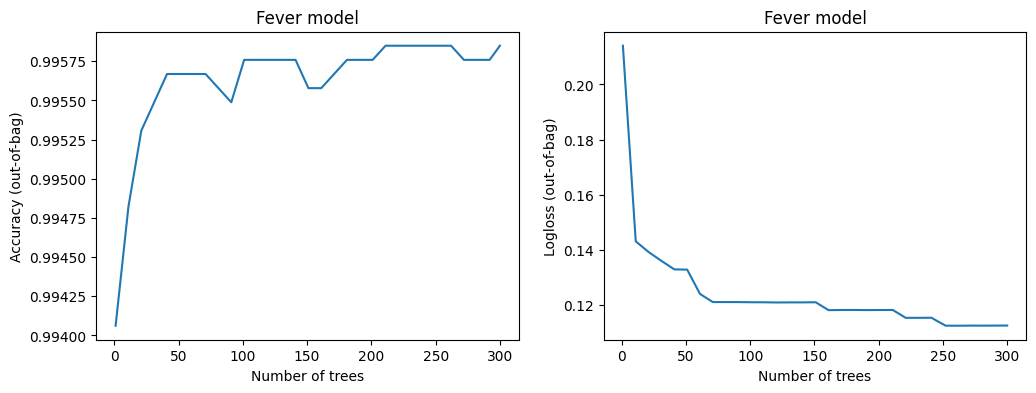

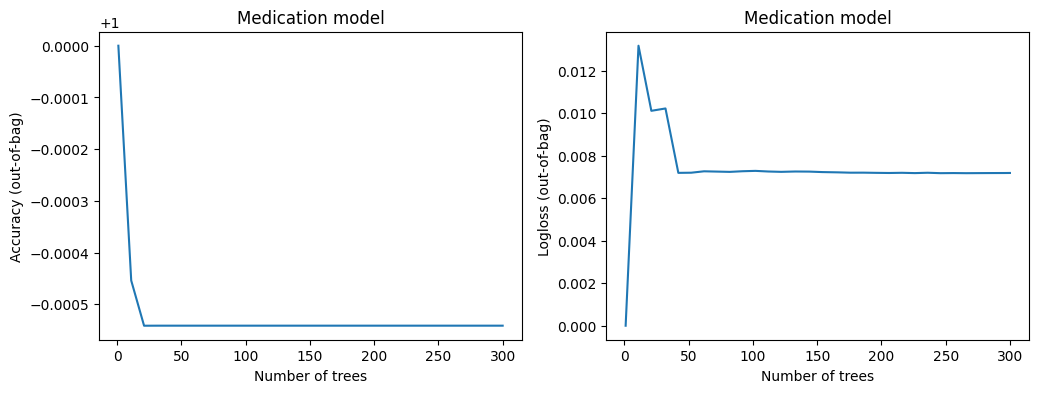

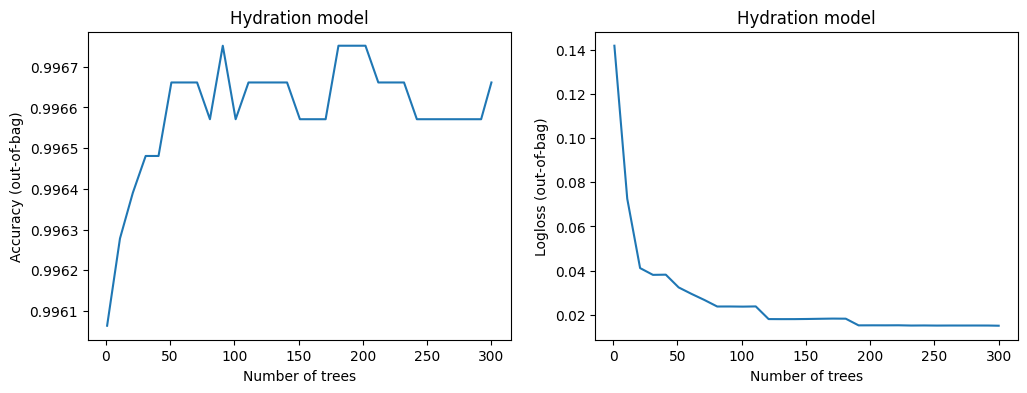

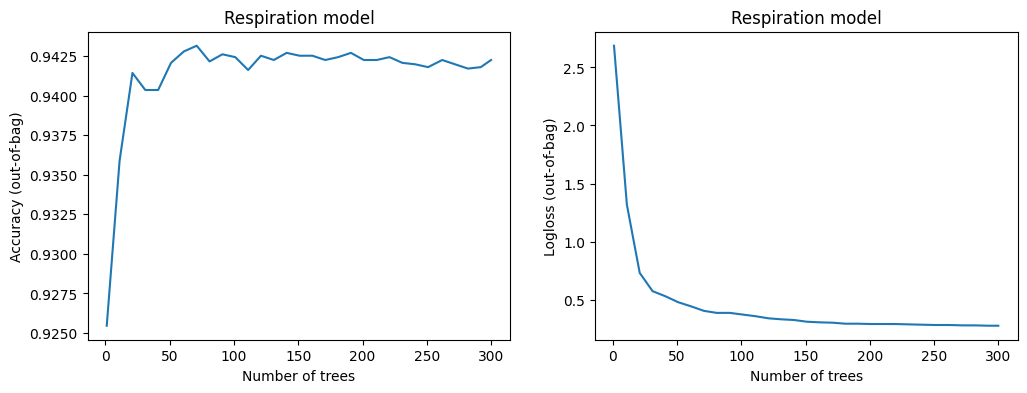

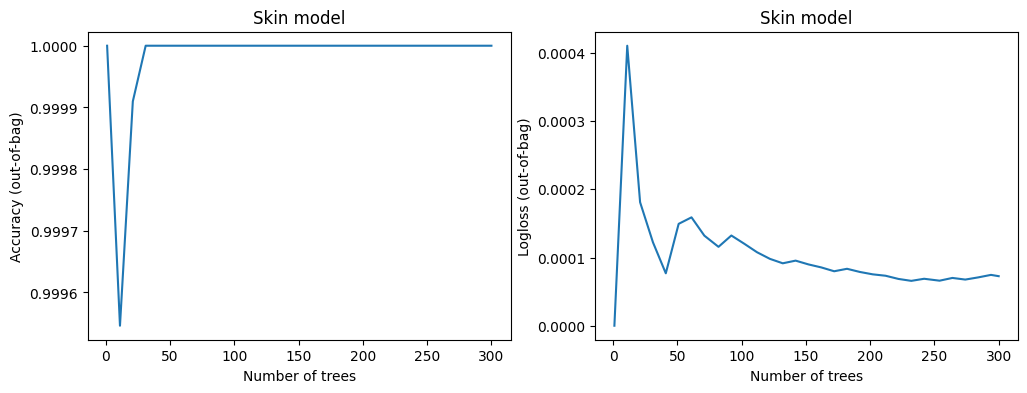

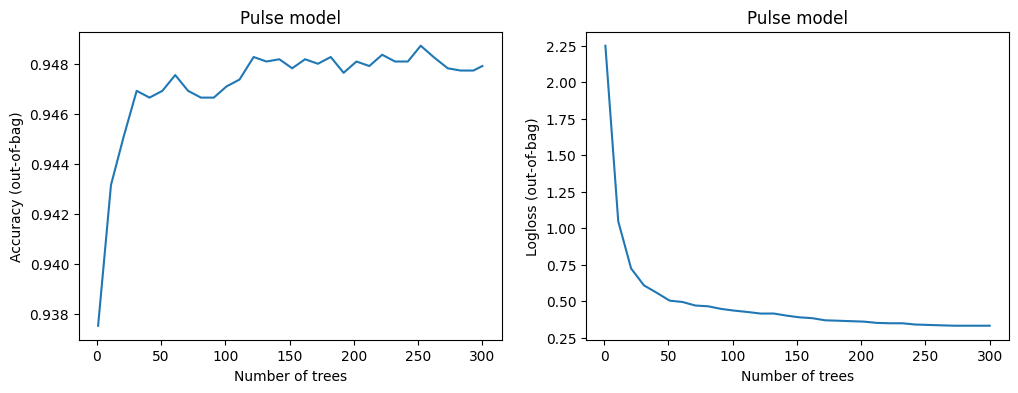

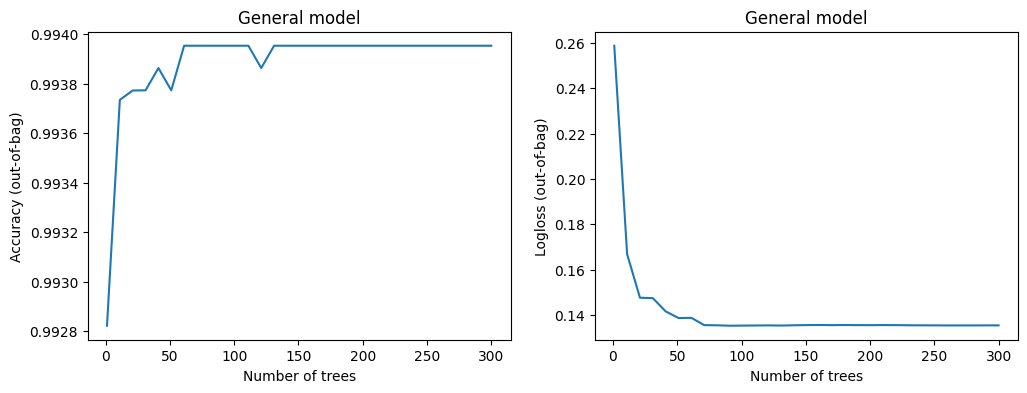

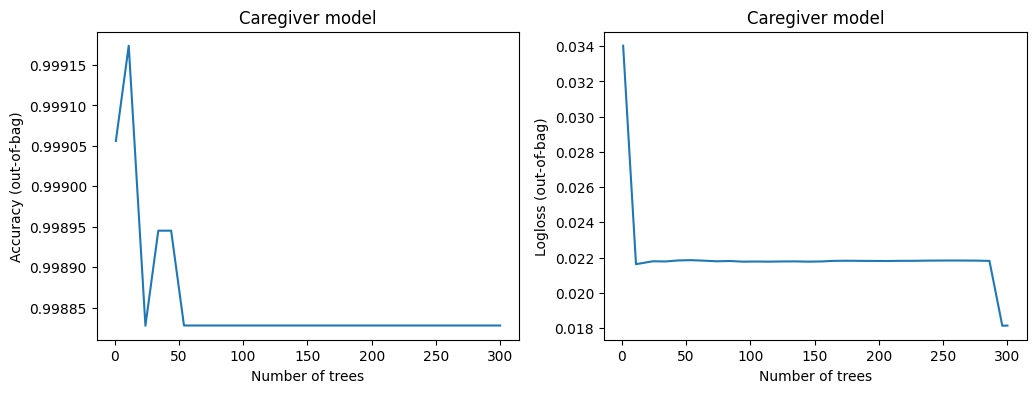

In [18]:
import matplotlib.pyplot as plt

for key, model in models.items():
    logs = model.make_inspector().training_logs()

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
        log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy (out-of-bag)")

    plt.subplot(1, 2, 2)
    plt.title(key.capitalize() + ' model')
    plt.plot([log.num_trees for log in logs], [
        log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Logloss (out-of-bag)")

    plt.show()


In [41]:
# Using decision forest for the whole dataset
x_train, y_train, x_val, y_val, x_test, y_test = split(
    df.drop(columns=all_labels),
    df[labels]
)
print("X shape:", x_train.shape)
model = create_model()
model.fit(x=x_train, y=y_train, validation_data=(x_val, y_val), verbose=0)

loss, acc = model.evaluate(x=x_test, y=y_test)

print('>>>')
print("acc: %f" % acc)


X shape: (11082, 45)
Use /tmp/tmpe05kvys6 as temporary training directory
Num validation examples: tf.Tensor(3694, shape=(), dtype=int32)


[INFO 2023-03-06T13:28:18.841148231+01:00 kernel.cc:1214] Loading model from path /tmp/tmpe05kvys6/model/ with prefix 2764ca1bf8904a60
[INFO 2023-03-06T13:28:19.210904825+01:00 decision_forest.cc:661] Model loaded with 300 root(s), 143498 node(s), and 44 input feature(s).
[INFO 2023-03-06T13:28:19.210934728+01:00 abstract_model.cc:1311] Engine "RandomForestGeneric" built
[INFO 2023-03-06T13:28:19.21095616+01:00 kernel.cc:1046] Use fast generic engine


116/116 [==============================] - 0s 2ms/step - loss: 0.0000e+00 - accuracy: 0.9367
>>>
acc: 0.936671


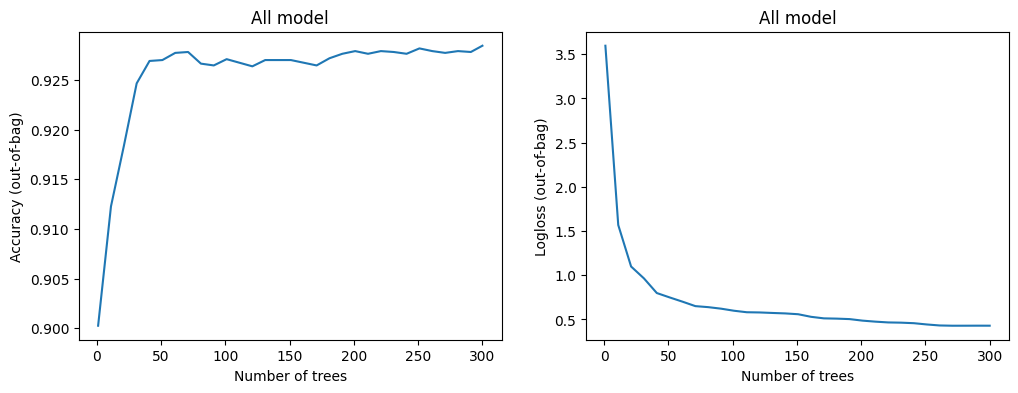

In [20]:
logs = model.make_inspector().training_logs()

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title('all'.capitalize() + ' model')
plt.plot([log.num_trees for log in logs], [
    log.evaluation.accuracy for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Accuracy (out-of-bag)")

plt.subplot(1, 2, 2)
plt.title('all'.capitalize() + ' model')
plt.plot([log.num_trees for log in logs], [
    log.evaluation.loss for log in logs])
plt.xlabel("Number of trees")
plt.ylabel("Logloss (out-of-bag)")

plt.show()

In [9]:
model.save('model/all')


INFO:tensorflow:Assets written to: model/all/assets


INFO:tensorflow:Assets written to: model/all/assets
